# Boolean Least Squares

A binary signal $s \in \{-1, 1\}^n$ is transmitted through a communication channel, and 
received as 
$$
y = As + v,
$$

where $v \sim \mathcal{N}(0, \sigma^2 I)$ is a noise, and $A \in \mathbb{R}^{m \times n}$ 
is the channel matrix. The maximum likelihood estimate of $s$ given $y$ is a solution of

$$
\min_{x} \; \|y - Ax\|_2 
\quad \text{subject to} \quad x_i^2 = 1, \; i = 1, \ldots, n,
$$

where $x$ is the optimization variable.

It is a boolean least squares problem if the objective function is squared.

Note that the square function in the constraint is elementwise.

## Numerical Examples

We consider some numerical examples with $m=n=100$, with $A_{ij} \sim \mathcal{N}(0,1)$ 
i.i.d., and $s_i$ i.i.d. with probability $1/2$ equal to $1$ or $-1$.  

The signal to noise ratio level is $n/\sigma^2$. In each of the 10 independent 
instances, $A$ and $s$ are generated, and $n/\sigma^2$ takes 8 values from 1 to 17.  

For each value of $n/\sigma^2$, $v$ is generated. The bit error rates averaged from 10 
instances are shown in the figure below.  

## Model definition

The following code will solve the boolean least squares problem using DCCP.

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

from dccp import is_dccp

# constants and noise parameters
n = 100
T = 1
noise_sigma = np.sqrt(n / np.linspace(1, 15, 8))
error = np.zeros((len(noise_sigma), T))
er_bit_rate = np.zeros((len(noise_sigma), T))
dis = np.zeros((len(noise_sigma), T))

rng = np.random.default_rng(seed=0)

# problem definition
x = cp.Variable((n, 1))
constr = [cp.square(x) == 1]

for t in range(T):
    A = rng.standard_normal((n, n))
    x0 = rng.integers(0, 2, size=(n, 1))
    x0 = x0 * 2 - 1
    for noise_idx in range(len(noise_sigma)):
        sigma = noise_sigma[noise_idx]
        v = rng.standard_normal((n, 1)) * sigma
        y = np.dot(A, x0) + v

        # solve by dccp
        prob = cp.Problem(cp.Minimize(cp.norm(A @ x - y)), constr)
        assert is_dccp(prob)
        result = prob.solve(method="dccp", seed=0)
        assert prob.status == cp.OPTIMAL, "problem not solved to optimality"
        assert x.value is not None, "solver failed"
        solution = [x_value.value for x_value in x]
        recover = np.array(solution)
        error[noise_idx, t] = np.linalg.norm(recover - x0, 2)
        er_bit_rate[noise_idx, t] = np.sum(np.abs(recover - x0) >= 1)

        # display results
        snr = n / (sigma**2)
        print(
            f"SNR: {snr:.2f}, Error: {error[noise_idx, t]:.4f}, "
            f"Bit error rate: {er_bit_rate[noise_idx, t]}"
        )

SNR: 1.00, Error: 10.7703, Bit error rate: 29.0
SNR: 3.00, Error: 6.0000, Bit error rate: 9.0
SNR: 5.00, Error: 4.8990, Bit error rate: 6.0
SNR: 7.00, Error: 4.0000, Bit error rate: 4.0
SNR: 9.00, Error: 0.0000, Bit error rate: 0.0
SNR: 11.00, Error: 0.0000, Bit error rate: 0.0
SNR: 13.00, Error: 0.0000, Bit error rate: 0.0
SNR: 15.00, Error: 0.0000, Bit error rate: 0.0


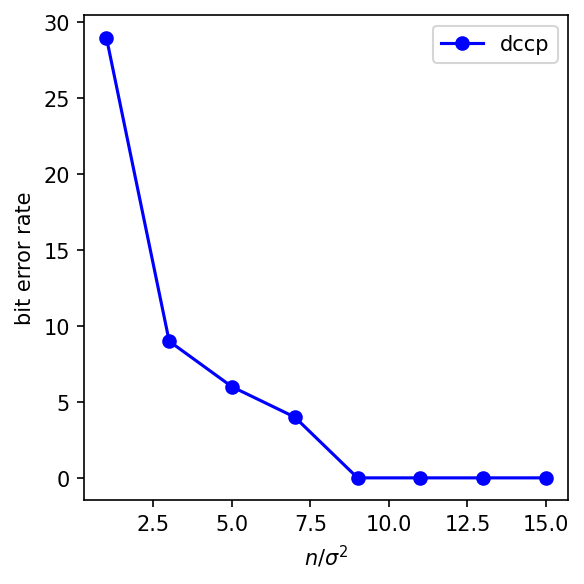

In [2]:
fig, ax = plt.subplots(figsize=(4, 4))
fig.set_dpi(150)

ax.plot(
    n / np.square(noise_sigma), np.sum(er_bit_rate, axis=1) / T, "b-o", label="dccp"
)
ax.set_xlabel("$n/\\sigma^2$")
ax.set_ylabel("bit error rate")
ax.legend()
fig.tight_layout()